<a href="https://colab.research.google.com/github/MohammadErfanRashidi/Waze-prediction-/blob/main/Waze_dataset_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Plan

In [70]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn import metrics

from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

from xgboost import plot_importance

In [2]:
# load df
df = pd.read_csv('/content/waze_dataset.csv')
df.head()

,ID,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,device
0,0,retained,283,226,296.748273,2276,208,0,2628.845068,1985.775061,28,19,Android
1,1,retained,133,107,326.896596,1225,19,64,13715.920550,3160.472914,13,11,iPhone
2,2,retained,114,95,135.522926,2651,0,0,3059.148818,1610.735904,14,8,Android
3,3,retained,49,40,67.589221,15,322,7,913.591123,587.196542,7,3,iPhone
4,4,retained,84,68,168.247020,1562,166,5,3950.202008,1219.555924,27,18,Android


# Analyze

In [3]:
# info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       14999 non-null  int64  
 1   label                    14299 non-null  object 
 2   sessions                 14999 non-null  int64  
 3   drives                   14999 non-null  int64  
 4   total_sessions           14999 non-null  float64
 5   n_days_after_onboarding  14999 non-null  int64  
 6   total_navigations_fav1   14999 non-null  int64  
 7   total_navigations_fav2   14999 non-null  int64  
 8   driven_km_drives         14999 non-null  float64
 9   duration_minutes_drives  14999 non-null  float64
 10  activity_days            14999 non-null  int64  
 11  driving_days             14999 non-null  int64  
 12  device                   14999 non-null  object 
dtypes: float64(3), int64(8), object(2)
memory usage: 1.5+ MB


In [4]:
# shape
df.shape

(14999, 13)

In [5]:
# describe
df.describe()

,ID,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,7499.000000,80.633776,67.281152,189.964447,1749.837789,121.605974,29.672512,4039.340921,1860.976012,15.537102,12.179879
std,4329.982679,80.699065,65.913872,136.405128,1008.513876,148.121544,45.394651,2502.149334,1446.702288,9.004655,7.824036
min,0.000000,0.000000,0.000000,0.220211,4.000000,0.000000,0.000000,60.441250,18.282082,0.000000,0.000000
25%,3749.500000,23.000000,20.000000,90.661156,878.000000,9.000000,0.000000,2212.600607,835.996260,8.000000,5.000000
50%,7499.000000,56.000000,48.000000,159.568115,1741.000000,71.000000,9.000000,3493.858085,1478.249859,16.000000,12.000000
75%,11248.500000,112.000000,93.000000,254.192341,2623.500000,178.000000,43.000000,5289.861262,2464.362632,23.000000,19.000000
max,14998.000000,743.000000,596.000000,1216.154633,3500.000000,1236.000000,415.000000,21183.401890,15851.727160,31.000000,30.000000


In [6]:
# divide driven_km_drives with driving_days and create a new column km_pe-driving_day
df['km_per_driving_day'] = df['driven_km_drives'] / df['driving_days']

df['km_per_driving_day'].describe()

,km_per_driving_day
count,1.499900e+04
mean,inf
std,NaN
min,3.022063e+00
25%,1.672804e+02
50%,3.231459e+02
75%,7.579257e+02
max,inf


In [7]:
# replace inf value with 0
df['km_per_driving_day'] = df['km_per_driving_day'].replace([np.inf, -np.inf], 0)

df['km_per_driving_day'].describe()

,km_per_driving_day
count,14999.000000
mean,578.963113
std,1030.094384
min,0.000000
25%,136.238895
50%,272.889272
75%,558.686918
max,15420.234110


In [8]:
# create a new column with the % of sessions of total_sessions
df['session_percentage'] = df['sessions'] / df['total_sessions']

df['session_percentage'].describe()

,session_percentage
count,14999.000000
mean,0.449255
std,0.286919
min,0.000000
25%,0.196221
50%,0.423097
75%,0.687216
max,1.530637


In [9]:
# create a professional_driver column where they had drive more than 50 times and drove more than 15 days
df['professional_driver'] = np.where((df['drives'] > 50) & (df['driving_days'] > 15), 1, 0)

df['professional_driver'].value_counts(normalize=True) * 100

,proportion
professional_driver,
0,81.818788
1,18.181212


In [10]:
# create a total_sessions_per_day column with n_days_after_onboarding
df['total_sessions_per_day'] = df['total_sessions'] / df['n_days_after_onboarding']

df['total_sessions_per_day'].describe()

,total_sessions_per_day
count,14999.000000
mean,0.338698
std,1.314333
min,0.000298
25%,0.051037
50%,0.100775
75%,0.216269
max,39.763874


In [11]:
# create km_per_hour column with driven_km_drives and duration_minutes_drives
df['km_per_hour'] = df['driven_km_drives'] / (df['duration_minutes_drives'] / 60)

df['km_per_hour'].describe()

,km_per_hour
count,14999.000000
mean,190.394608
std,334.674026
min,72.013095
25%,90.706222
50%,122.382022
75%,193.130119
max,23642.920871


As seen above, we have problematic numbers that are worth investigating further.

In [12]:
# create km per driver column
df['km_per_driver'] = df['driven_km_drives'] / df['drives']

df['km_per_driver'].describe()

,km_per_driver
count,1.499900e+04
mean,inf
std,NaN
min,1.008775e+00
25%,3.323065e+01
50%,7.488006e+01
75%,1.854667e+02
max,inf


In [13]:
# converting inf values to 0
df['km_per_driver'] = df['km_per_driver'].replace([np.inf, -np.inf], 0)

df['km_per_driver'].describe()

,km_per_driver
count,14999.000000
mean,232.817946
std,620.622351
min,0.000000
25%,32.424301
50%,72.854343
75%,179.347527
max,15777.426560


In [14]:
df.head()

,ID,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,device,km_per_driving_day,session_percentage,professional_driver,total_sessions_per_day,km_per_hour,km_per_driver
0,0,retained,283,226,296.748273,2276,208,0,2628.845068,1985.775061,28,19,Android,138.360267,0.953670,1,0.130381,79.430298,11.632058
1,1,retained,133,107,326.896596,1225,19,64,13715.920550,3160.472914,13,11,iPhone,1246.901868,0.406856,0,0.266854,260.389902,128.186173
2,2,retained,114,95,135.522926,2651,0,0,3059.148818,1610.735904,14,8,Android,382.393602,0.841186,0,0.051121,113.953460,32.201567
3,3,retained,49,40,67.589221,15,322,7,913.591123,587.196542,7,3,iPhone,304.530374,0.724968,0,4.505948,93.351141,22.839778
4,4,retained,84,68,168.247020,1562,166,5,3950.202008,1219.555924,27,18,Android,219.455667,0.499266,1,0.107713,194.342970,58.091206


In [15]:
# add fav1 and fav2 and divide them by total_sessions for percent of fav
df['percent_of_fav'] = (
    df['total_navigations_fav1'] + df['total_navigations_fav2']) / df['total_sessions']

df['percent_of_fav'].describe()

,percent_of_fav
count,14999.000000
mean,1.665439
std,8.865666
min,0.000000
25%,0.203471
50%,0.649818
75%,1.638526
max,777.563629


In [16]:
# check for missing values
df.isna().sum()

,0
ID,0
label,700
sessions,0
drives,0
total_sessions,0
n_days_after_onboarding,0
total_navigations_fav1,0
total_navigations_fav2,0
driven_km_drives,0
duration_minutes_drives,0


In [17]:
# drop missing values
df = df.dropna()

df.isna().sum()

,0
ID,0
label,0
sessions,0
drives,0
total_sessions,0
n_days_after_onboarding,0
total_navigations_fav1,0
total_navigations_fav2,0
driven_km_drives,0
duration_minutes_drives,0


In [18]:
# check df columns datatypes
df.dtypes

,0
ID,int64
label,object
sessions,int64
drives,int64
total_sessions,float64
n_days_after_onboarding,int64
total_navigations_fav1,int64
total_navigations_fav2,int64
driven_km_drives,float64
duration_minutes_drives,float64


In [19]:
# check devices column
df['device'].value_counts()

,count
device,
iPhone,9225
Android,5074


In [20]:
# encode to 0 and 1
df['device'] = np.where(df['device'] == 'Android', 1, 0)

df['device'].value_counts()

,count
device,
0,9225
1,5074


In [21]:
# check label column
df['label'].value_counts()

,count
label,
retained,11763
churned,2536


In [22]:
# encode label column
df['label'] = np.where(df['label'] == 'churned', 1, 0)

df['label'].value_counts()

,count
label,
0,11763
1,2536


In [23]:
# check info again looking for obj
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14299 entries, 0 to 14998
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       14299 non-null  int64  
 1   label                    14299 non-null  int64  
 2   sessions                 14299 non-null  int64  
 3   drives                   14299 non-null  int64  
 4   total_sessions           14299 non-null  float64
 5   n_days_after_onboarding  14299 non-null  int64  
 6   total_navigations_fav1   14299 non-null  int64  
 7   total_navigations_fav2   14299 non-null  int64  
 8   driven_km_drives         14299 non-null  float64
 9   duration_minutes_drives  14299 non-null  float64
 10  activity_days            14299 non-null  int64  
 11  driving_days             14299 non-null  int64  
 12  device                   14299 non-null  int64  
 13  km_per_driving_day       14299 non-null  float64
 14  session_percentage       14

In [24]:
# drop ID column
df = df.drop('ID', axis=1)

df.head()

,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,device,km_per_driving_day,session_percentage,professional_driver,total_sessions_per_day,km_per_hour,km_per_driver,percent_of_fav
0,0,283,226,296.748273,2276,208,0,2628.845068,1985.775061,28,19,1,138.360267,0.953670,1,0.130381,79.430298,11.632058,0.700931
1,0,133,107,326.896596,1225,19,64,13715.920550,3160.472914,13,11,0,1246.901868,0.406856,0,0.266854,260.389902,128.186173,0.253903
2,0,114,95,135.522926,2651,0,0,3059.148818,1610.735904,14,8,1,382.393602,0.841186,0,0.051121,113.953460,32.201567,0.000000
3,0,49,40,67.589221,15,322,7,913.591123,587.196542,7,3,0,304.530374,0.724968,0,4.505948,93.351141,22.839778,4.867640
4,0,84,68,168.247020,1562,166,5,3950.202008,1219.555924,27,18,1,219.455667,0.499266,1,0.107713,194.342970,58.091206,1.016363


In [26]:
# check label balance
df['label'].value_counts(normalize=True)

,proportion
label,
0,0.822645
1,0.177355


# Construct

In [27]:
# split the data into x and y
X = df.drop('label', axis=1)
y = df['label']

In [31]:
# create train and test data with stratify with y
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

In [32]:
# split into train and validate
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

In [ ]:
# create the model
rf = RandomForestClassifier(random_state=42)

# define the hyperparameters: max_depth, max_depth, max_features, max_samples, min_samples_leaf, min_samples_split, n_estimators
param_grid = {
    'max_depth': [5, 10, 15],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_samples': [0.5, 0.75, 1.0],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [100, 200, 300]
}

In [35]:
rf = RandomForestClassifier(random_state=42)

# define the hyperparameters: max_depth, max_depth, max_features, max_samples, min_samples_leaf, min_samples_split, n_estimators
param_grid = {
    'max_depth': [5, 10, 15],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_samples': [0.5, 0.75, 1.0],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [100, 200, 300]
}

# scoring list
scoring = ['accuracy', 'precision', 'recall', 'f1']

# create the RandomizedSearchCV object
rf_cv = RandomizedSearchCV(rf, param_grid, cv=5, scoring=scoring, refit='recall')

In [36]:
# fit the model
rf_cv.fit(X_train, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
20 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.12/dist-packages/sklearn/utils/_

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   param_distributions={'max_depth': [5, 10, 15],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'max_samples': [0.5, 0.75, 1.0],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300]},
                   refit='recall',
                   scoring=['accuracy', 'precision', 'recall', 'f1'])

In [37]:
# examine the best score
rf_cv.best_score_

np.float64(0.10414245014245013)

In [38]:
# best parameters
rf_cv.best_params_

{'n_estimators': 200,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_samples': 1.0,
 'max_features': 'sqrt',
 'max_depth': 15}

In [39]:
def make_results(model_name:str, model_object, metric:str):
    '''
    Arguments:
        model_name (string): what you want the model to be called in the output table
        model_object: a fit GridSearchCV object
        metric (string): precision, recall, f1, or accuracy

    Returns a pandas df with the F1, recall, precision, and accuracy scores
    for the model with the best mean 'metric' score across all validation folds.
    '''

    # Create dictionary that maps input metric to actual metric name in GridSearchCV
    metric_dict = {'precision': 'mean_test_precision',
                   'recall': 'mean_test_recall',
                   'f1': 'mean_test_f1',
                   'accuracy': 'mean_test_accuracy',
                   }

    # Get all the results from the CV and put them in a df
    cv_results = pd.DataFrame(model_object.cv_results_)

    # Isolate the row of the df with the max(metric) score
    best_estimator_results = cv_results.iloc[cv_results[metric_dict[metric]].idxmax(), :]

    # Extract accuracy, precision, recall, and f1 score from that row
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy

    # Create table of results
    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision],
                          'recall': [recall],
                          'F1': [f1],
                          'accuracy': [accuracy],
                          },
                         )

    return table

In [41]:
results = make_results('RF cv', rf_cv, 'recall')
results.head()

,model,precision,recall,F1,accuracy
0,RF cv,0.519939,0.104142,0.173326,0.823954


In [44]:
# create XGBoost model, binary-logistic
xgb = XGBClassifier(objective='binary:logistic', random_state=42)

# define hyperparamerters
param_grid = {
    'max_depth': [5, 10, 15],
    'learning_rate': [0.01, 0.1],
    'min_child_weight': [1, 2, 4],
    'n_estimators': [100, 200, 300],
}

# scoring list
scoring = ['accuracy', 'precision', 'recall', 'f1']

# create the RandomizedSearchCV object
xgb_cv = RandomizedSearchCV(xgb, param_grid, cv=5, scoring=scoring, refit='recall')

In [45]:
# fit the model
xgb_cv.fit(X_train, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.p

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           feature_weights=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constrain...
                                           max_delta_step=None, max_depth=None,
                                           max_leaves=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None, ...),
                   param_distributions={'learning_rate': [0.01, 0.1],
                                        'max_depth': [5, 10, 15],
                                        'min_child_weight': [1, 2, 4],
                                        'n_estimators': [100, 200, 300]},
                   refit='recall',
                   scoring=['accuracy', 'precision', 'recall', 'f1'])

In [46]:
# best score
xgb_cv.best_score_

np.float64(0.1657511870845204)

In [47]:
# best parameters
xgb_cv.best_params_

{'n_estimators': 300,
 'min_child_weight': 1,
 'max_depth': 10,
 'learning_rate': 0.1}

In [49]:
# call make_results function on xgb_cv and cpncat it to the table
results = pd.concat([results, make_results('XGBoost cv', xgb_cv, 'recall')])
results.head()

,model,precision,recall,F1,accuracy
0,RF cv,0.519939,0.104142,0.173326,0.823954
0,XGBoost cv,0.443440,0.165751,0.241130,0.815211


In [50]:
# rf on validate data with best estimator
rf_val_preds = rf_cv.best_estimator_.predict(X_val)

In [54]:
def get_test_scores(model_name:str, preds, y_test_data):
    '''
    Generate a table of test scores.

    In:
        model_name (string): Your choice: how the model will be named in the output table
        preds: numpy array of test predictions
        y_test_data: numpy array of y_test data

    Out:
        table: a pandas df of precision, recall, f1, and accuracy scores for your model
    '''
    accuracy = accuracy_score(y_test_data, preds)
    precision = precision_score(y_test_data, preds)
    recall = recall_score(y_test_data, preds)
    f1 = f1_score(y_test_data, preds)

    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision],
                          'recall': [recall],
                          'F1': [f1],
                          'accuracy': [accuracy]
                          })

    return table

In [55]:
# concat val preds
results = pd.concat([results, get_test_scores('RF val', rf_val_preds, y_val)])
results.head()

,model,precision,recall,F1,accuracy
0,RF cv,0.519939,0.104142,0.173326,0.823954
0,XGBoost cv,0.443440,0.165751,0.241130,0.815211
0,RF val,0.433333,0.096059,0.157258,0.817308


In [56]:
# xgb on val
xgb_val_preds = xgb_cv.best_estimator_.predict(X_val)

results = pd.concat([results, get_test_scores('XGBoost val', xgb_val_preds, y_val)])
results.head()

,model,precision,recall,F1,accuracy
0,RF cv,0.519939,0.104142,0.173326,0.823954
0,XGBoost cv,0.443440,0.165751,0.241130,0.815211
0,RF val,0.433333,0.096059,0.157258,0.817308
0,XGBoost val,0.400000,0.142857,0.210526,0.809878


In [58]:
# find the best model with recall score
results.sort_values(by='recall', ascending=False).head(1)

,model,precision,recall,F1,accuracy
0,XGBoost cv,0.44344,0.165751,0.24113,0.815211


# Execute

In [59]:
# use xgb model to predict test
xgb_test_preds = xgb_cv.best_estimator_.predict(X_test)

# get the scores
results = pd.concat([results, get_test_scores('XGB test', xgb_test_preds, y_test)])
results.head()

,model,precision,recall,F1,accuracy
0,RF cv,0.519939,0.104142,0.173326,0.823954
0,XGBoost cv,0.443440,0.165751,0.241130,0.815211
0,RF val,0.433333,0.096059,0.157258,0.817308
0,XGBoost val,0.400000,0.142857,0.210526,0.809878
0,XGB test,0.407767,0.165680,0.235624,0.809441


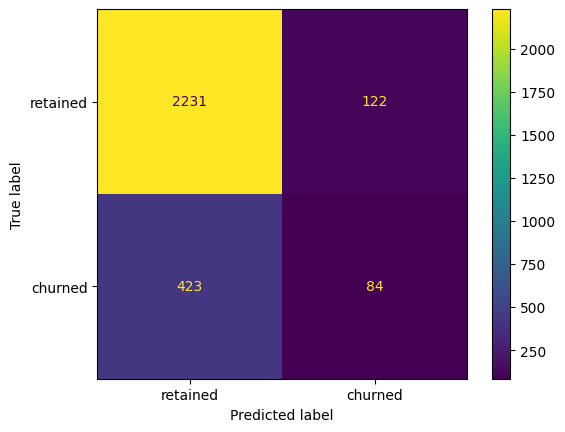

In [64]:
# array of values for confusion matrix
cm = confusion_matrix(y_test, xgb_test_preds, labels=xgb_cv.classes_)

# plot the matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=['retained', 'churned'])
disp.plot();

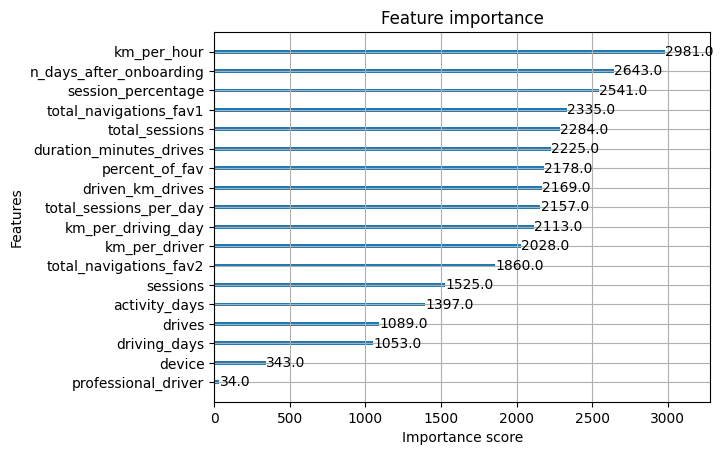

In [72]:
# plot importance on chart
plot_importance(xgb_cv.best_estimator_)

plt.show()